In [1]:
import xarray as xr
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, glob, re, time, math, calendar

# import custom functions
sys.path.append('/')
from libraries import *
from plotters import *

# NYSM Profilers vs NOW23  vs ML, hexbins of coefficients

In [13]:
def hexbin_plotter(fig,gs,Y,pred,title,text_arg=None,xlabel=None,ylabel=None):
    '''
    Plots hebxin between true and predictions of Y
    fig: figure handle
    gs: grid spect handle
    Y: target (train or test or true) 
    pred: prediction from a model
    title: title of the figure
    text_arg: whether to add text with in the plot or not
    xlabel_arg: some cases, the xlabel is not needed, this specifies that
    ylabel_arg: some cases, the ylabel is not needed, this specifies that 
    '''
    errMAE    = mae(Y,pred)
    errRMSE   = np.sqrt(mse(Y,pred))
    errMAPE   = mape(Y,pred)
    errR2     = R2(Y,pred)

    ax_hexbin = fig.add_subplot(gs)
    hb = ax_hexbin.hexbin(np.squeeze(Y), np.squeeze(pred), gridsize=100, bins='log', cmap='inferno')
    if text_arg:
        ax_hexbin.text(0.05, 0.93, f'$R^2$: {errR2:.2f}\nRMSE: {errRMSE:.2f}',
                      transform=ax_hexbin.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    if xlabel:
        ax_hexbin.set_xlabel(xlabel)
    if ylabel:
        ax_hexbin.set_ylabel(ylabel)
    ax_hexbin.set_title(f'{title}')

    min_value = Y.min()
    max_value = Y.max()
    ax_hexbin.set_xlim(min_value, max_value)
    ax_hexbin.set_ylim(min_value, max_value)
    ax_hexbin.plot([min_value, max_value], [min_value, max_value], 'k--')

Segregated times: 11902
Intersected times: 11629
(11629, 32) (11629, 5)
Segregated times: 16272
Intersected times: 15829
(15829, 32) (15829, 5)
Segregated times: 14682
Intersected times: 14393
(14393, 32) (14393, 5)
Segregated times: 12523
Intersected times: 12217
(12217, 32) (12217, 5)
Segregated times: 16161
Intersected times: 15833
(15833, 32) (15833, 5)
Segregated times: 5518
Intersected times: 5347
(5347, 32) (5347, 5)
Segregated times: 10762
Intersected times: 10429
(10429, 32) (10429, 5)
Segregated times: 8156
Intersected times: 8110
(8110, 32) (8110, 5)
Segregated times: 10492
Intersected times: 10492
(10492, 32) (10492, 5)
Segregated times: 18446
Intersected times: 18043
(18043, 32) (18043, 5)
Segregated times: 16941
Intersected times: 16569
(16569, 32) (16569, 5)
Segregated times: 13816
Intersected times: 13587
(13587, 32) (13587, 5)
Segregated times: 15541
Intersected times: 15216
(15216, 32) (15216, 5)
(167694, 5) (167694, 5) (167694, 18) (167694, 18) (167694, 18)
1.9128726

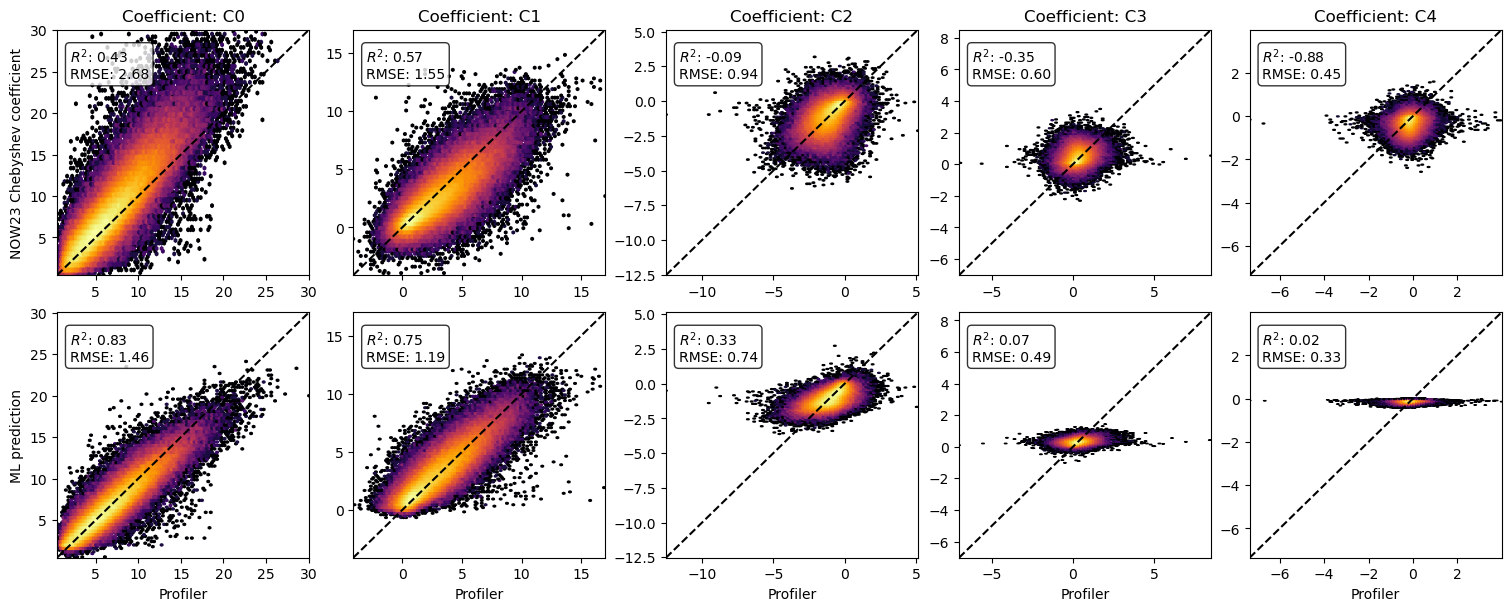

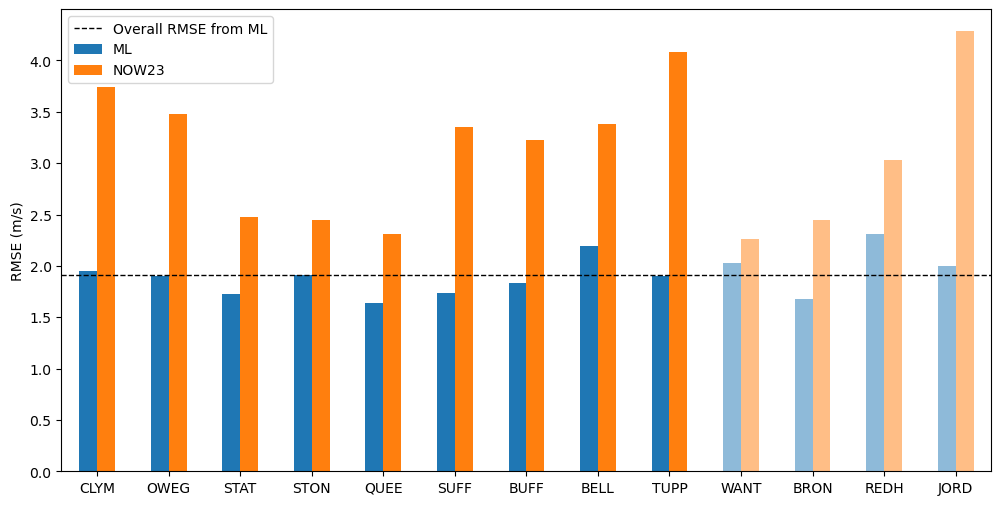

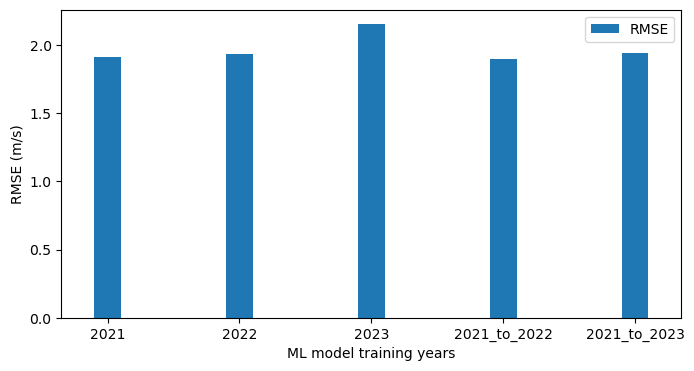

In [61]:
# === Input parameters ===
input_file = 'data/ERA5.nc'
input_variables = [
    "10ws", "100ws", "100alpha", "975ws", "950ws", "975wsgrad", "950wsgrad",
    "zust", "i10fg", "t2m", "skt", "stl1", "d2m", "msl", "blh", "ishf", 
    "ie", "tcc", "lcc", "cape", "bld", "t_975", "t_950", "2mtempgrad", 
    "sktempgrad", "dewtempsprd", "975tempgrad", "950tempgrad", "sinHR", 
    "cosHR", "sinJDAY", "cosJDAY"
]
input_times_freq = 1 #ratio between the target times and input times, 12 for NOW23 data
target_variables = [0,1,2,3,4]

experiment = f'ERA5_to_profilers'
tabnet_param_file = 'best_model_params.csv'
hourly_data_method = 'Averaged_over_55th_to_5th_min'
segregated = 'segregated'
transformed = 'not_transformed'
loss_function = 'MSE_loss'
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

test_station_ids = ['PROF_CLYM','PROF_OWEG','PROF_STAT','PROF_STON','PROF_QUEE','PROF_SUFF','PROF_BUFF','PROF_BELL','PROF_TUPP',
                    'PROF_WANT','PROF_BRON','PROF_REDH','PROF_JORD']
test_dates_range = ('2018-01-01T00:00:00', '2020-12-31T23:00:00')

RMSE_all = {}
ml_models = ['2021','2022','2023','2021_to_2022','2021_to_2023']
for ml_model in ml_models:
    RMSE_all[ml_model] = []
    X_test_all, Y_test_all = [], []
    Y_pred_all = []
    profiler_coeff_all, NOW23_coeff_all = [], []
    profiler_profiles_all, NOW23_profiles_all, ML_profiles_all = [], [] ,[]
    RMSE_stations = {}
    for station_id in test_station_ids:
        Coeff_file = f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_id}.nc'

        if segregated == 'segregated':
            segregate_arg = True
        else:
            segregate_arg = None
        X_test, Y_test, time_coord = data_processing(input_file,Coeff_file,
                                        input_times_freq,input_variables,target_variables,test_dates_range,station_id,val_arg=None, segregate_arg=segregate_arg)
        print(X_test.shape, Y_test.shape)

        # ML prediction
        Ens = 9
        model_output_dir = f'trained_models/{experiment}/9_stations/{hourly_data_method}/{ml_model}/{segregated}/{transformed}/{loss_function}/Ens{Ens}'
        fSTR = f'{model_output_dir}/TabNet_HOLDOUT.pkl'
        with open(fSTR, "rb") as f:
            tabReg = pickle.load(f)

        Y_pred = tabReg.predict(X_test)

        if transformed == 'transformed':
            min_max_scaler = joblib.load(f'{model_output_dir}/min_max_scaler.joblib')
            Y_pred = min_max_scaler.inverse_transform(Y_pred)

        Y_pred_all.append(Y_pred)

        # profiler and NOW23 data
        profiler_ds = xr.open_dataset(f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_id}.nc').Chebyshev_Coefficients
        NOW23_ds = xr.open_dataset(f'data/NOW23_Chebyshev_Coefficients/{station_id}.nc').Chebyshev_Coefficients

        profiler_coeff = profiler_ds.sel(time=slice(*test_dates_range,input_times_freq)).where(profiler_ds.outlier == 1, drop=True)
        profiler_coeff = profiler_coeff.sel(time=time_coord)
        NOW23_coeff = NOW23_ds.sel(time=time_coord)
        profiler_coeff_all.append(profiler_coeff)
        NOW23_coeff_all.append(NOW23_coeff)

        # true profiler and NOW23 data
        profiler_profiles_ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/Averaged_over_55th_to_5th_min/{station_id}.nc').wind_speed
        NOW23_profiles_ds = xr.open_dataset(f'data/NOW23_profiles/{station_id}.nc').wind_speed

        profiler_profiles = profiler_profiles_ds.sel(range=slice(10,500),time=time_coord).T
        NOW23_profiles = NOW23_profiles_ds.sel(time=time_coord)
        profiler_profiles_all.append(profiler_profiles)

        # profiles from coefficients
        ML_profiles = WindProfile(profilers_levels, Y_pred.T, poly_order=4, CPtype=1, ref_H=ref_H)
        ML_profiles = ML_profiles.T

        NOW23_profiles = WindProfile(profilers_levels, NOW23_coeff.values.T, poly_order=4, CPtype=1, ref_H=ref_H)
        NOW23_profiles = NOW23_profiles.T

        ML_profiles_all.append(ML_profiles)
        NOW23_profiles_all.append(NOW23_profiles)

        RMSE_ML = np.sqrt(np.nanmean((profiler_profiles.values - ML_profiles)**2))
        RMSE_NOW23 = np.sqrt(np.nanmean((profiler_profiles.values - NOW23_profiles)**2))
        RMSE_stations[station_id[5:]] = [RMSE_ML, RMSE_NOW23]

    if len(test_station_ids) > 1:
        profiler_coeff_all = xr.concat(profiler_coeff_all, dim='time')
        NOW23_coeff_all = xr.concat(NOW23_coeff_all, dim='time')
        Y_pred_all = np.concatenate(Y_pred_all, axis=0)
        profiler_profiles_all = xr.concat(profiler_profiles_all, dim='time')
        NOW23_profiles_all = np.concatenate(NOW23_profiles_all, axis=0)
        ML_profiles_all = np.concatenate(ML_profiles_all, axis=0)

    else:
        profiler_coeff_all = profiler_coeff_all[0]
        NOW23_coeff_all = NOW23_coeff_all[0]
        Y_pred_all = Y_pred_all[0]
        profiler_profiles_all = profiler_profiles_all[0]
        NOW23_profiles_all = NOW23_profiles_all[0]
        ML_profiles_all = ML_profiles_all[0]

    print(profiler_coeff_all.shape, NOW23_coeff_all.shape, profiler_profiles_all.shape, NOW23_profiles_all.shape, ML_profiles_all.shape)

    # Computing RMSE of the ML and NOW23 profiles, for each ML model, and create a dataframe
    RMSE_ML = np.sqrt(np.nanmean((profiler_profiles_all.values - ML_profiles_all)**2))
    RMSE_all[ml_model] = RMSE_ML
    print(RMSE_ML)

    if ml_model == '2021':
        # plotting the hexbins
        fig = plt.figure(figsize=(15, 6), constrained_layout=True)
        gs = fig.add_gridspec(2,5)
        row = 0
        for coeff in range(5):
            col = coeff
            ylabel = f'NOW23 Chebyshev coefficient' if col == 0 else ''
            xlabel = 'Profiler Chebyshev coefficient' if row == 1 else ''
            title = f'Coefficient: C{coeff}' if row == 0 else ''
            hexbin_plotter(fig,gs[row,col],profiler_coeff_all.sel(coeff=coeff),
                        NOW23_coeff_all.sel(coeff=coeff),
                        title,text_arg=True, xlabel=xlabel, ylabel=ylabel)
        row = 1
        for coeff in range(5):
            col = coeff
            ylabel = f'ML prediction' if col == 0 else ''
            xlabel = 'Profiler' if row == 1 else ''
            title = f'Coefficient: C{coeff}' if row == 0 else ''
            hexbin_plotter(fig,gs[row,col],profiler_coeff_all.sel(coeff=coeff),
                        Y_pred_all[:,coeff],
                        title,text_arg=True, xlabel=xlabel, ylabel=ylabel)
        
        plt.savefig(f'NAWEA/{ml_model}_Coefficients_hexbin.png', bbox_inches='tight', dpi=300)

        # ploting the RMSEs for each station, from ML and NOW, in a bar plot
        RMSE_stations = pd.DataFrame(RMSE_stations, index=['ML','NOW23']).T
        ax = RMSE_stations.plot(kind='bar', rot=0, width=0.5,figsize=(12, 6))

        # Set alpha values to 0.8 for the last four stations
        alpha_values = [1.0] * (len(RMSE_stations) - 4) + [0.5] * 4
        for bar, alpha in zip(ax.containers[0], alpha_values):  # First set of bars (ML)
            bar.set_alpha(alpha)
        for bar, alpha in zip(ax.containers[1], alpha_values):  # Second set of bars (NOW23)
            bar.set_alpha(alpha)
        
        # draw a dashed line, RMSE_all['2021']
        ax.axhline(y=RMSE_ML, color='k', linestyle='--', linewidth=1, label='Overall RMSE from ML')
        # show the legend
        ax.legend()

        plt.ylabel('RMSE (m/s)')
        plt.savefig(f'NAWEA/{ml_model}_RMSE_stations.png', bbox_inches='tight', dpi=300)

# Plotting the RMSE of the ML models
RMSE_ml_models = pd.DataFrame(RMSE_all, index=['RMSE']).T
ax = RMSE_ml_models.plot(kind='bar', rot=0, width=0.2, figsize=(8, 4))

# Label the y-axis and save the figure
plt.ylabel('RMSE (m/s)')
plt.xlabel('ML model training years')
plt.savefig(f'NAWEA/ML_models_RMSE.png')

# Plotting wind profiles

In [68]:
x = np.arange(-1, 1, 0.01)
CPtype = 1
CP = Chebyshev_Basu(x, 4, CPtype)
p = 4
def chebyshev_polynomials_plotter(gs):
    ax = fig.add_subplot(gs)
    
    ax.plot(CP[:, 0], x, '-r', linewidth=2,label='T_0')
    ax.plot(CP[:, 1], x, '-b', linewidth=2,label='T_1')
    ax.plot(CP[:, 2], x, '-m', linewidth=2,label='T_2')
    ax.plot(CP[:, 3], x, '--g', linewidth=2,label='T_3')
    ax.plot(CP[:, 4], x, '--y', linewidth=2,label='T_4')
    
    #ax.legend(['T_0', 'T_1', 'T_2', 'T_3', 'T_4'], loc='upper right', fontsize=14)
    #ax.set_xlabel('Coefficients', fontsize=18)
    ax.set_ylabel('Normalized Height', fontsize=18)
    ax.set_title('Chebyshev Polynomials', fontsize=18)
    # Set ticks
    ax.set_xticks(np.arange(-1, 1.1, 0.5))
    ax.set_yticks(np.arange(-1, 1.1, 0.5))
    # Set tick font size
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)

    return ax

def profle_plotter_(gs,Z,coeff,M,Mp,title,xlabel=None,ylabel=None,legend=None,text_loc=None):
    ax = fig.add_subplot(gs)
    ax.plot(M, Z, 'or', markerfacecolor='r',label='Observed profile')
    ax.plot(Mp, Z, '-k', linewidth=2,label='Chebyshev modelled profile')

    if text_loc:
        ax.text(text_loc[0], text_loc[1], f'C0 = {coeff[0]:.2f} \nC1 = {coeff[1]:.2f}'
            f'\nC2 = {coeff[2]:.2f} \nC3 = {coeff[3]:.2f} \nC4 = {coeff[4]:.2f}',
                      transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),fontsize=14)

    ax.set_xlim([0, 30])
    ax.set_ylim([0, 500])
    ax.tick_params(labelsize=14)
    ax.set_title(title,fontsize=18)
    if xlabel:
        ax.set_xlabel(xlabel,fontsize=18)
    if ylabel:
        ax.set_ylabel(ylabel,fontsize=18)
    if legend:
        ax.legend()

    return ax

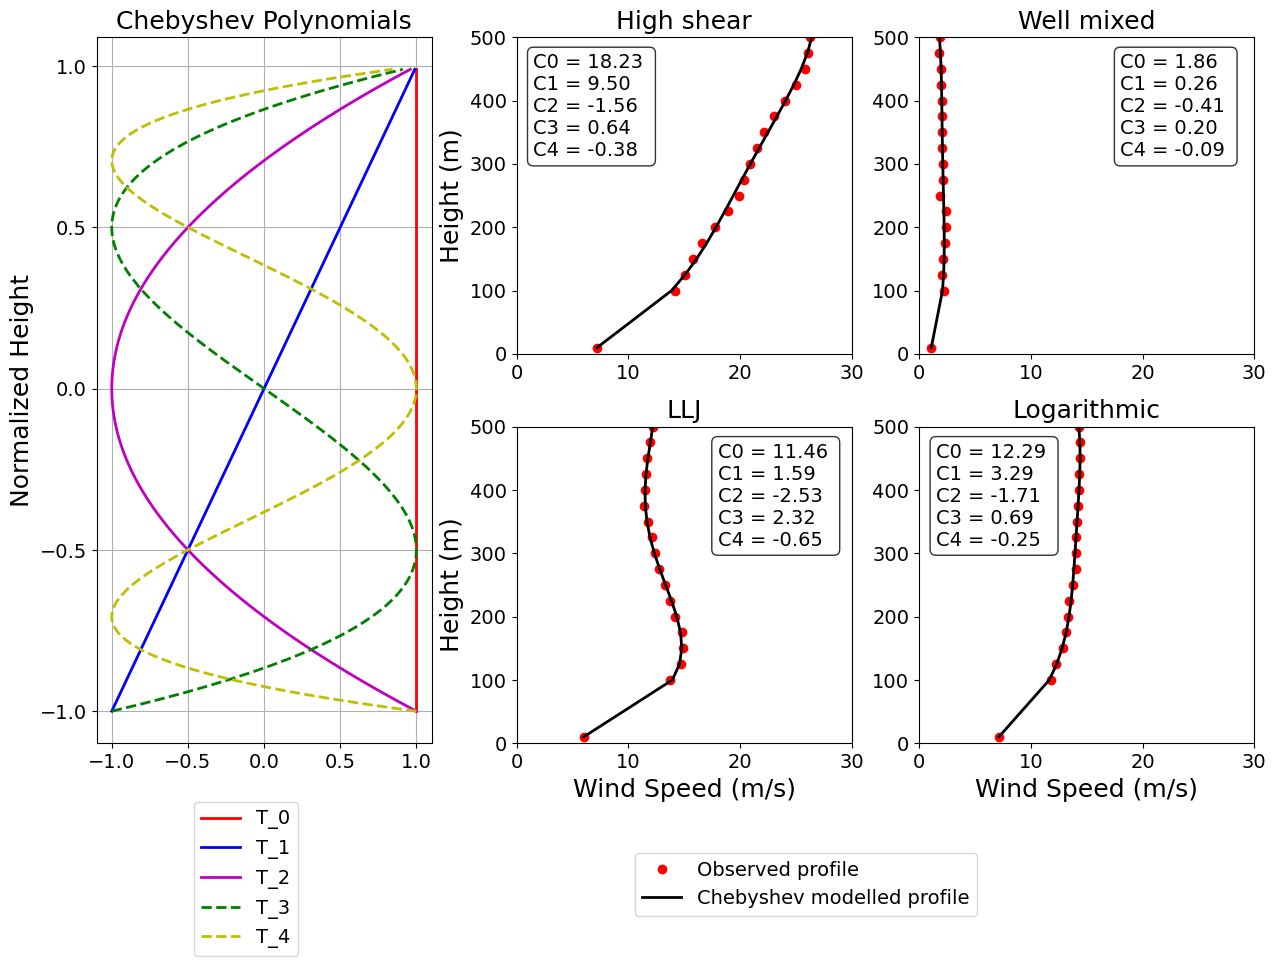

In [72]:
wind_regimes = ['High shear','Well mixed','LLJ','Logarithmic']
station_ids = ['PROF_BRON','PROF_BRON','PROF_WANT','PROF_BRON']
time_instances = ['2020-05-01T00','2019-08-05T01','2018-04-06T20','2019-04-27T13']
text_locs = [[0.05, 0.95],[0.6, 0.95],[0.6, 0.95],[0.05, 0.95]]

fig = plt.figure(figsize=(16, 8), constrained_layout=True)
gs = fig.add_gridspec(2,4)
axs = chebyshev_polynomials_plotter(gs[0:2,0])
# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.15, -0.2),fontsize=14)
for k,profile in enumerate(wind_regimes):
    col = (k%2)+1
    row = k//2
    xlabel = 'Wind Speed (m/s)' if row == 1 else None
    ylabel = 'Height (m)' if col == 1 else None
    legend = None
    time_coord = time_instances[k]
    profiler_profiles_ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/Averaged_over_55th_to_5th_min/{station_ids[k]}.nc').wind_speed
    M = profiler_profiles_ds.sel(range=slice(10,500),time=time_coord).T
    profiler_ds = xr.open_dataset(f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_ids[k]}.nc').Chebyshev_Coefficients
    profiler_coeff = profiler_ds.sel(time=slice(*test_dates_range,input_times_freq)).where(profiler_ds.outlier == 1, drop=True)
    profiler_coeff = profiler_ds.sel(time=time_coord)
    Mp = WindProfile(profilers_levels, profiler_coeff.values.T, poly_order=4, CPtype=1, ref_H=ref_H)

    axs = profle_plotter_(gs[row,col],profilers_levels,profiler_coeff,M,Mp,profile,xlabel=xlabel,ylabel=ylabel,legend=legend,text_loc=text_locs[k])
# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.5, -0.15),fontsize=14)
plt.savefig(f'NAWEA/Chebyshev_profiles.png', bbox_inches='tight', dpi=300)


## Wind profiles comparison between Obs, MOW23, and ML

Segregated times: 1
Intersected times: 1
(1, 32) (1, 5)
Segregated times: 1
Intersected times: 1
(1, 32) (1, 5)
Segregated times: 1
Intersected times: 1
(1, 32) (1, 5)
Segregated times: 1
Intersected times: 1
(1, 32) (1, 5)


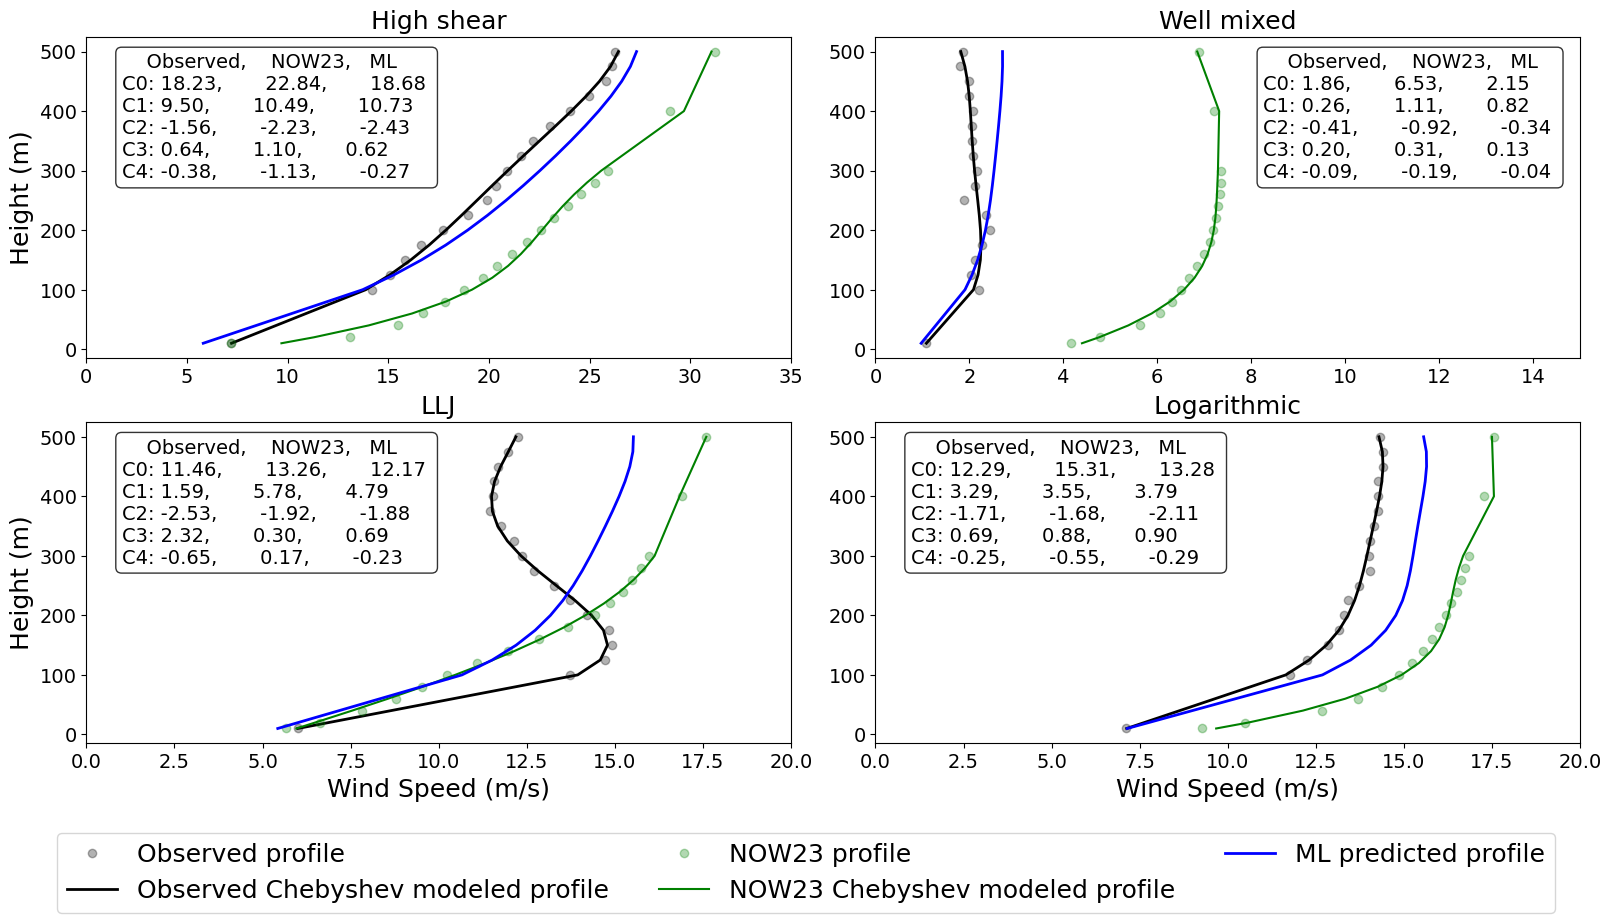

In [149]:
wind_regimes = ['High shear','Well mixed','LLJ','Logarithmic']
station_ids = ['PROF_BRON','PROF_BRON','PROF_WANT','PROF_BRON']
time_instances = ['2020-05-01T00:00','2019-08-05T01:00','2018-04-06T20:00','2019-04-27T13:00']
text_locs = [[0.05, 0.95],[0.55, 0.95],[0.05, 0.95],[0.05, 0.95]]
x_lims = [[0, 35],[0, 15],[0, 20],[0, 20]]

fig = plt.figure(figsize=(16, 8), constrained_layout=True)
gs = fig.add_gridspec(2,2)
for k,profile in enumerate(wind_regimes):

    col = (k%2)
    row = k//2
    axes = fig.add_subplot(gs[row,col])

    time_coord = time_instances[k]

    # Observed profile
    profiler_profiles_ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/Averaged_over_55th_to_5th_min/{station_ids[k]}.nc').wind_speed
    M = profiler_profiles_ds.sel(range=slice(10,500),time=time_coord).T

    profiler_ds = xr.open_dataset(f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_ids[k]}.nc').Chebyshev_Coefficients
    profiler_coeff = profiler_ds.sel(time=slice(*test_dates_range,input_times_freq)).where(profiler_ds.outlier == 1, drop=True)
    profiler_coeff = profiler_ds.sel(time=time_coord)
    Mp = WindProfile(profilers_levels, profiler_coeff.values.T, poly_order=4, CPtype=1, ref_H=ref_H)
    axes.plot(M, profilers_levels, 'ok', markerfacecolor='k', label='Observed profile', alpha=0.3)
    axes.plot(Mp, profilers_levels, '-k', linewidth=2, label='Observed Chebyshev modeled profile')

    # NOW23 data
    NOW23_profiles_ds = xr.open_dataset(f'data/NOW23_profiles/{station_ids[k]}.nc').wind_speed
    NOW23_profiles = NOW23_profiles_ds.sel(time=time_coord).values.T
    axes.plot(NOW23_profiles, z_NOW23, 'og', linewidth=2, label='NOW23 profile', alpha=0.3)
    NOW23_ds = xr.open_dataset(f'data/NOW23_Chebyshev_Coefficients/{station_ids[k]}.nc').Chebyshev_Coefficients
    NOW23_coeff = NOW23_ds.sel(time=time_coord).values.T
    z_NOW23 = NOW23_levels
    Mp_NOW23 = WindProfile(z_NOW23, NOW23_coeff, poly_order=4, CPtype=1, ref_H=ref_H)
    axes.plot(Mp_NOW23, z_NOW23, '-g', markerfacecolor='g', label='NOW23 Chebyshev modeled profile')

    # ML profiles
    Coeff_file = f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_ids[k]}.nc'
    if segregated == 'segregated':
        segregate_arg = True
    else:
        segregate_arg = None
    X_test, Y_test, _ = data_processing(input_file,Coeff_file,
                                    input_times_freq,input_variables,target_variables,(time_instances[k],time_instances[k]),station_ids[k],val_arg=None, segregate_arg=segregate_arg)
    print(X_test.shape, Y_test.shape)
    # ML prediction
    Ens = 9
    ml_model = '2021'
    model_output_dir = f'trained_models/{experiment}/9_stations/{hourly_data_method}/{ml_model}/{segregated}/{transformed}/{loss_function}/Ens{Ens}'
    fSTR = f'{model_output_dir}/TabNet_HOLDOUT.pkl'
    with open(fSTR, "rb") as f:
        tabReg = pickle.load(f)
    Y_pred = tabReg.predict(X_test)

    if transformed == 'transformed':
        min_max_scaler = joblib.load(f'{model_output_dir}/min_max_scaler.joblib')
        Y_pred = min_max_scaler.inverse_transform(Y_pred)
    Y_pred = Y_pred.reshape(-1,1)
    z_ml = profilers_levels
    Mp_ml = WindProfile(z_ml, Y_pred, poly_order=4, CPtype=1, ref_H=ref_H)

    axes.plot(Mp_ml, z_ml, '-b', label='ML predicted profile',linewidth=2)

    # Show the Coefficients
    axes.text(text_locs[k][0], text_locs[k][1],
              f'    Observed,    NOW23,   ML \n' 
              f'C0: {profiler_coeff[0]:.2f},       {NOW23_coeff[0]:.2f},       {Y_pred[0][0]:.2f} \n'
              f'C1: {profiler_coeff[1]:.2f},       {NOW23_coeff[1]:.2f},       {Y_pred[1][0]:.2f} \n'
              f'C2: {profiler_coeff[2]:.2f},       {NOW23_coeff[2]:.2f},       {Y_pred[2][0]:.2f} \n'
              f'C3: {profiler_coeff[3]:.2f},       {NOW23_coeff[3]:.2f},       {Y_pred[3][0]:.2f} \n'
              f'C4: {profiler_coeff[4]:.2f},       {NOW23_coeff[4]:.2f},       {Y_pred[4][0]:.2f}', 
              transform=axes.transAxes, verticalalignment='top', 
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=14)

    xlabel = 'Wind Speed (m/s)' if row == 1 else None
    ylabel = 'Height (m)' if col == 0 else None
    title = profile

    if xlabel:
        axes.set_xlabel(xlabel, fontsize=18)
    if ylabel:
        axes.set_ylabel(ylabel, fontsize=18)

    axes.tick_params(labelsize=14)
    axes.set_xlim(x_lims[k])
    axes.set_title(title, fontsize=18)
    
# Extract legend from one of the subplots
handles, labels = axes.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15),fontsize=18)
plt.savefig(f'NAWEA/Wind_profiles_comparison.png', bbox_inches='tight', dpi=300)

Segregated times: 1
Intersected times: 1
(1, 32) (1, 5)


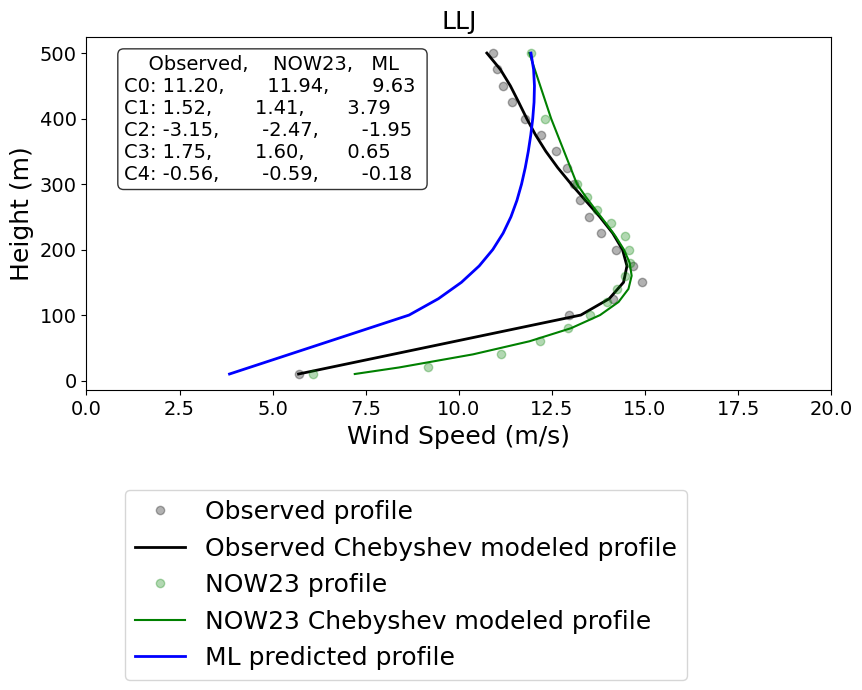

In [150]:
wind_regimes = ['High shear','Well mixed','LLJ','Logarithmic']
station_ids = ['PROF_BRON','PROF_BRON','PROF_WANT','PROF_BRON']
time_instances = ['2020-05-01T00:00','2019-08-05T01:00','2019-09-23T22:00','2019-04-27T13:00']
text_locs = [[0.05, 0.95],[0.55, 0.95],[0.05, 0.95],[0.05, 0.95]]
x_lims = [[0, 35],[0, 15],[0, 20],[0, 20]]

fig = plt.figure(figsize=(16, 8), constrained_layout=True)
gs = fig.add_gridspec(2,2)
k = 2
profile = wind_regimes[k]

col = (k%2)
row = k//2
axes = fig.add_subplot(gs[row,col])

time_coord = time_instances[k]

# Observed profile
profiler_profiles_ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/Averaged_over_55th_to_5th_min/{station_ids[k]}.nc').wind_speed
M = profiler_profiles_ds.sel(range=slice(10,500),time=time_coord).T

profiler_ds = xr.open_dataset(f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_ids[k]}.nc').Chebyshev_Coefficients
profiler_coeff = profiler_ds.sel(time=slice(*test_dates_range,input_times_freq)).where(profiler_ds.outlier == 1, drop=True)
profiler_coeff = profiler_ds.sel(time=time_coord)
Mp = WindProfile(profilers_levels, profiler_coeff.values.T, poly_order=4, CPtype=1, ref_H=ref_H)
axes.plot(M, profilers_levels, 'ok', markerfacecolor='k', label='Observed profile', alpha=0.3)
axes.plot(Mp, profilers_levels, '-k', linewidth=2, label='Observed Chebyshev modeled profile')

# NOW23 data
NOW23_profiles_ds = xr.open_dataset(f'data/NOW23_profiles/{station_ids[k]}.nc').wind_speed
NOW23_profiles = NOW23_profiles_ds.sel(time=time_coord).values.T
axes.plot(NOW23_profiles, z_NOW23, 'og', linewidth=2, label='NOW23 profile', alpha=0.3)
NOW23_ds = xr.open_dataset(f'data/NOW23_Chebyshev_Coefficients/{station_ids[k]}.nc').Chebyshev_Coefficients
NOW23_coeff = NOW23_ds.sel(time=time_coord).values.T
z_NOW23 = NOW23_levels
Mp_NOW23 = WindProfile(z_NOW23, NOW23_coeff, poly_order=4, CPtype=1, ref_H=ref_H)
axes.plot(Mp_NOW23, z_NOW23, '-g', markerfacecolor='g', label='NOW23 Chebyshev modeled profile')

# ML profiles
Coeff_file = f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_ids[k]}.nc'
if segregated == 'segregated':
    segregate_arg = True
else:
    segregate_arg = None
X_test, Y_test, _ = data_processing(input_file,Coeff_file,
                                input_times_freq,input_variables,target_variables,(time_instances[k],time_instances[k]),station_ids[k],val_arg=None, segregate_arg=segregate_arg)
print(X_test.shape, Y_test.shape)
# ML prediction
Ens = 9
ml_model = '2021'
model_output_dir = f'trained_models/{experiment}/9_stations/{hourly_data_method}/{ml_model}/{segregated}/{transformed}/{loss_function}/Ens{Ens}'
fSTR = f'{model_output_dir}/TabNet_HOLDOUT.pkl'
with open(fSTR, "rb") as f:
    tabReg = pickle.load(f)
Y_pred = tabReg.predict(X_test)

if transformed == 'transformed':
    min_max_scaler = joblib.load(f'{model_output_dir}/min_max_scaler.joblib')
    Y_pred = min_max_scaler.inverse_transform(Y_pred)
Y_pred = Y_pred.reshape(-1,1)
z_ml = profilers_levels
Mp_ml = WindProfile(z_ml, Y_pred, poly_order=4, CPtype=1, ref_H=ref_H)

axes.plot(Mp_ml, z_ml, '-b', label='ML predicted profile',linewidth=2)

# Show the Coefficients
axes.text(text_locs[k][0], text_locs[k][1],
            f'    Observed,    NOW23,   ML \n' 
            f'C0: {profiler_coeff[0]:.2f},       {NOW23_coeff[0]:.2f},       {Y_pred[0][0]:.2f} \n'
            f'C1: {profiler_coeff[1]:.2f},       {NOW23_coeff[1]:.2f},       {Y_pred[1][0]:.2f} \n'
            f'C2: {profiler_coeff[2]:.2f},       {NOW23_coeff[2]:.2f},       {Y_pred[2][0]:.2f} \n'
            f'C3: {profiler_coeff[3]:.2f},       {NOW23_coeff[3]:.2f},       {Y_pred[3][0]:.2f} \n'
            f'C4: {profiler_coeff[4]:.2f},       {NOW23_coeff[4]:.2f},       {Y_pred[4][0]:.2f}', 
            transform=axes.transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=14)

xlabel = 'Wind Speed (m/s)' if row == 1 else None
ylabel = 'Height (m)' if col == 0 else None
title = profile

if xlabel:
    axes.set_xlabel(xlabel, fontsize=18)
if ylabel:
    axes.set_ylabel(ylabel, fontsize=18)

axes.tick_params(labelsize=14)
axes.set_xlim(x_lims[k])
axes.set_title(title, fontsize=18)

# Extract legend from one of the subplots
handles, labels = axes.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.25, -.3),fontsize=18)
plt.savefig(f'NAWEA/Wind_profiles_comparison_LLJ.png', bbox_inches='tight', dpi=300)

# Feature importance

In [153]:
nELI5max = 1 #FIXME
def myELI5(model,X,y,multiout=None,target_variable=None):
    '''
    Calculates the feature importance using the ELI5 methodology
    model: saved ML model
    X: Input matrix
    y: target vector, since the feature importane is designed for one target variable at a time
    multiout: whether the model is trained with multioutput mode
    target_variable: if the model is trained with multioutput mode, we need to specify the target variable from the prediction
    '''
    nSamples, nFeatures = np.shape(X)
    iTot = np.arange(0,nSamples,1)
    
    #Original prediction
    if multiout:
        y_pred_org = model.predict(X)[:,target_variable]
    else:
        y_pred_org = model.predict(X)
    E_org      = np.sqrt(mse(y,y_pred_org)) 
    
    featImp = np.zeros(nFeatures)
    for nF in range(nFeatures):

        E_shfl_tot = 0
        for nELI5 in range(nELI5max):
            
            X_shfl = np.copy(X)

            np.random.shuffle(iTot)

            dum          = X_shfl[:,nF]
            X_shfl[:,nF] = dum[iTot]
            X_shfl       = pd.DataFrame(data=X_shfl)
            if multiout:
                y_pred_shfl  = model.predict(X_shfl.values)[:,target_variable]
            else:
                y_pred_shfl  = model.predict(X_shfl.values)
            E_shfl       = np.sqrt(mse(y,y_pred_shfl))

            E_shfl_tot   = E_shfl_tot + E_shfl

        #print(nF,E_org,E_shfl_tot/nELI5/E_org)
        featImp[nF] = (E_shfl_tot/nELI5max - E_org)*100/E_org
        
    return featImp

In [151]:
# === Input parameters ===
input_file = 'data/ERA5.nc'
input_variables = [
    "10ws", "100ws", "100alpha", "975ws", "950ws", "975wsgrad", "950wsgrad",
    "zust", "i10fg", "t2m", "skt", "stl1", "d2m", "msl", "blh", "ishf", 
    "ie", "tcc", "lcc", "cape", "bld", "t_975", "t_950", "2mtempgrad", 
    "sktempgrad", "dewtempsprd", "975tempgrad", "950tempgrad", "sinHR", 
    "cosHR", "sinJDAY", "cosJDAY"
]
input_times_freq = 1 #ratio between the target times and input times, 12 for NOW23 data
target_variables = [0,1,2,3,4]

experiment = f'ERA5_to_profilers'
tabnet_param_file = 'best_model_params.csv'
hourly_data_method = 'Averaged_over_55th_to_5th_min'
segregated = 'segregated'
transformed = 'not_transformed'
loss_function = 'MSE_loss'
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

test_station_ids = ['PROF_CLYM','PROF_OWEG','PROF_STAT','PROF_STON','PROF_QUEE','PROF_SUFF','PROF_BUFF','PROF_BELL','PROF_TUPP',
                    'PROF_WANT','PROF_BRON','PROF_REDH','PROF_JORD']
test_dates_range = ('2018-01-01T00:00:00', '2020-12-31T23:00:00')

ml_model = '2021'
X_test_all, Y_test_all = [], []
for station_id in test_station_ids:
    Coeff_file = f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_id}.nc'

    if segregated == 'segregated':
        segregate_arg = True
    else:
        segregate_arg = None
    X_test, Y_test, time_coord = data_processing(input_file,Coeff_file,
                                    input_times_freq,input_variables,target_variables,test_dates_range,station_id,val_arg=None, segregate_arg=segregate_arg)
    print(X_test.shape, Y_test.shape)
    X_test_all.append(X_test)
    Y_test_all.append(Y_test)

if len(test_station_ids) > 1:
    X_test_all = np.concatenate(X_test_all, axis=0)
    Y_test_all = np.concatenate(Y_test_all, axis=0)

else:
    X_test_all = X_test_all[0]
    Y_test_all = Y_test_all[0]
print(X_test_all.shape, Y_test_all.shape)

# ML prediction
Ens = 9
model_output_dir = f'trained_models/{experiment}/9_stations/{hourly_data_method}/{ml_model}/{segregated}/{transformed}/{loss_function}/Ens{Ens}'
fSTR = f'{model_output_dir}/TabNet_HOLDOUT.pkl'
with open(fSTR, "rb") as f:
    tabReg = pickle.load(f)

Y_pred = tabReg.predict(X_test_all)

if transformed == 'transformed':
    min_max_scaler = joblib.load(f'{model_output_dir}/min_max_scaler.joblib')
    Y_pred = min_max_scaler.inverse_transform(Y_pred)

Segregated times: 11902
Intersected times: 11629
(11629, 32) (11629, 5)
Segregated times: 16272
Intersected times: 15829
(15829, 32) (15829, 5)
Segregated times: 14682
Intersected times: 14393
(14393, 32) (14393, 5)
Segregated times: 12523
Intersected times: 12217
(12217, 32) (12217, 5)
Segregated times: 16161
Intersected times: 15833
(15833, 32) (15833, 5)
Segregated times: 5518
Intersected times: 5347
(5347, 32) (5347, 5)
Segregated times: 10762
Intersected times: 10429
(10429, 32) (10429, 5)
Segregated times: 8156
Intersected times: 8110
(8110, 32) (8110, 5)
Segregated times: 10492
Intersected times: 10492
(10492, 32) (10492, 5)
Segregated times: 18446
Intersected times: 18043
(18043, 32) (18043, 5)
Segregated times: 16941
Intersected times: 16569
(16569, 32) (16569, 5)
Segregated times: 13816
Intersected times: 13587
(13587, 32) (13587, 5)
Segregated times: 15541
Intersected times: 15216
(15216, 32) (15216, 5)
(167694, 32) (167694, 5)


<Axes: >

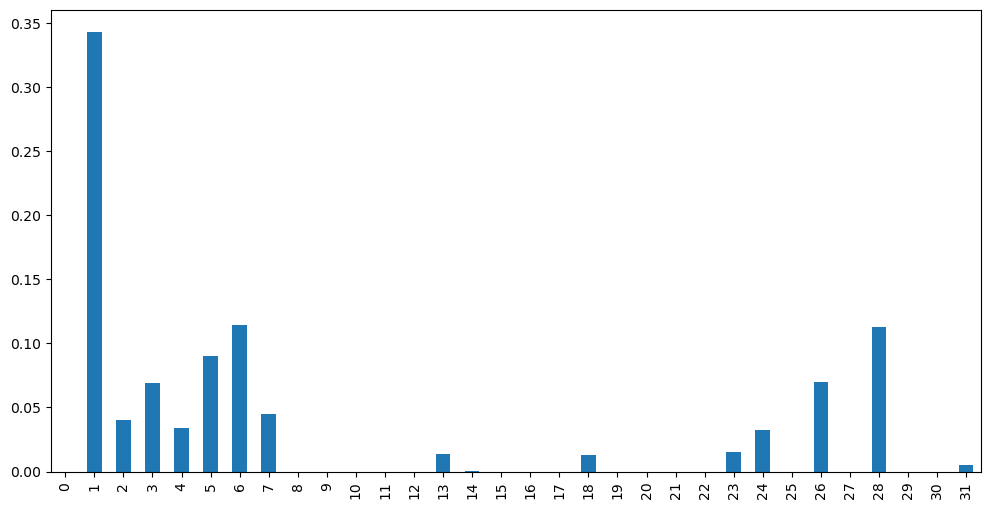

In [210]:
pd.Series(tabReg.feature_importances_).plot(kind='bar', figsize=(12, 6))

In [158]:
feature_Importance = []
# individual target variable feature importance
for coeff in target_variables:
    featImp = myELI5(tabReg,X_test_all,Y_test_all[:,coeff],multiout=True,target_variable=coeff)
    feature_Importance.append(featImp)
# all target variables feature importance
feature_Importance.append(myELI5(tabReg,X_test_all,Y_test_all))

In [174]:
# create a dataframe
feature_Importance_df = pd.DataFrame(np.array(feature_Importance).T, columns=[f'C{coeff}' for coeff in target_variables]+['All'])
feature_Importance_df

,C0,C1,C2,C3,C4,All
0,2.604567,5.314061,0.619526,0.208598,0.015143,2.993485
1,114.298462,23.972114,35.325396,10.792860,1.415206,73.648807
2,1.772248,5.109721,6.154868,0.237273,0.123533,3.219185
3,5.393016,7.447361,4.411730,0.523569,0.031668,5.473290
4,3.014380,4.307742,0.356095,-0.036004,0.029802,2.975713
5,11.925817,34.179965,7.631261,2.627482,-0.021715,18.263395
6,20.906006,37.772069,13.597523,3.860304,-0.011556,24.383019
7,2.048010,0.974045,0.195286,-0.074139,0.010938,1.299146
8,3.259611,4.870875,0.400241,0.090178,0.000253,3.288996
9,-0.069335,-0.171307,0.026976,0.016082,0.007365,-0.082852


In [168]:
input_variables_ = [
    r'$\mathbf{W}_{10}$',
    r'$\mathbf{W}_{100}$',
    r'$\mathbf{\alpha}$',
    r'$\mathbf{W}_{975}$',
    r'$\mathbf{W}_{950}$',
    r'$\Delta \mathbf{W}_{975-100}$',
    r'$\Delta \mathbf{W}_{950-975}$',
    r'$\mathbf{u}_*$',
    r'$\mathbf{W}_{p10}^i$',
    r'$T_2$',
    r'$T_0$',
    r'$T_s$',
    r'$T_{d2}$',
    r'$P_0$',
    r'$\mathbf{H}$',
    r'$H_S$',
    r'$H_L$',
    r'TCC',
    r'LCC',
    r'CAPE',
    r'$\bar{\epsilon}$',
    r'$T_{975}$',
    r'$T_{950}$',
    r'$\Delta T_1$',
    r'$\Delta T_2$',
    r'$\Delta T_3$',
    r'$\Delta T_4$',
    r'$\Delta T_5$',
    r'HRSin',
    r'HRCos',
    r'DYSin',
    r'DYCos']
len(input_variables_)

32

In [184]:
# convert target variables into 

[0, 1, 2, 3, 4, 'all']

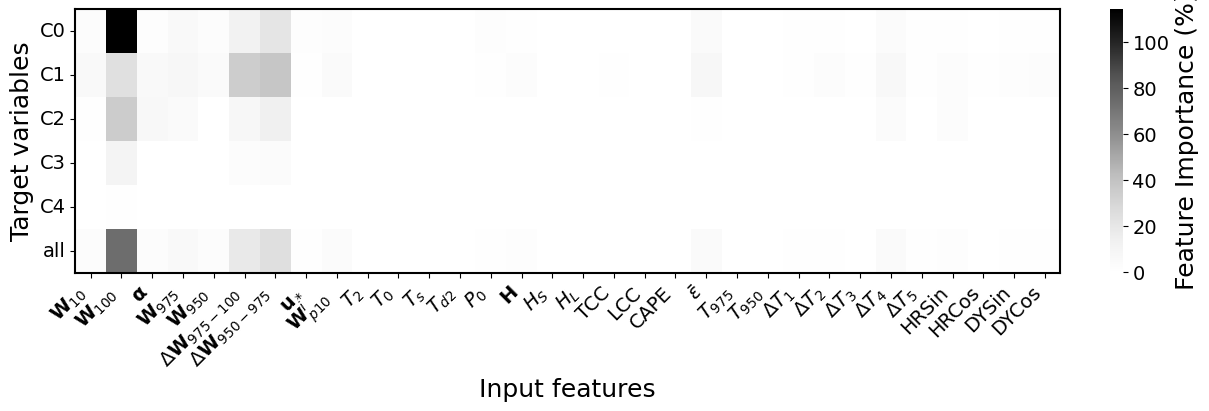

In [207]:
fig = plt.figure(figsize=(12, 4), constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])

# Transpose the data to match input_features on x-axis and target_variables on y-axis
sns.heatmap(
    feature_Importance_df.T,  # No transpose needed here since we already swapped
    cmap='Greys',
    fmt=".1f",
    cbar_kws={'label': 'Feature Importance (%)'},
    ax=ax
)

# Set axis labels and tick labels
ax.set_xticklabels(input_variables_, rotation=45, ha="right")
ax.set_yticklabels(['C0', 'C1', 'C2', 'C3', 'C4', 'all'], rotation=0)
ax.set_xlabel('Input features', fontsize=18)
ax.set_ylabel('Target variables', fontsize=18)
ax.tick_params(labelsize=14)

# Adjust color bar label font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.label.set_size(18)

# Add bounding box around the heatmap
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')  # Set color of the bounding box
    spine.set_linewidth(1.5)  # Set the thickness of the bounding box



In [47]:
from sklearn.cluster import KMeans
data = profiler_data.values  # Convert to 2D array: [time, coeffs]

# Apply k-means clustering
n_clusters = 64
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)  # Specify n_clusters as needed
labels = kmeans.labels_

In [48]:
# Add the labels as a new coordinate in the profiler_data
profiler_data = profiler_data.assign_coords(cluster=('time', labels))
NOW23_data = NOW23_data.assign_coords(cluster=('time', labels))
profiler_true_data = profiler_true_data.assign_coords(cluster=('time', labels))
NOW23_true_data = NOW23_true_data.assign_coords(cluster=('time', labels))
X_test = xr.DataArray(X_test, dims=['time','input_features'], coords={'time':profiler_data.time, 'input_features':input_variables}).assign_coords(cluster=('time', labels))
Y_test = xr.DataArray(Y_test, dims=['time','coeff'], coords={'time':profiler_data.time, 'coeff':['C0','C1','C2','C3','C4']}).assign_coords(cluster=('time', labels))

Cluster 0: (366, 18)
Cluster 1: (324, 18)
Cluster 2: (127, 18)
Cluster 3: (693, 18)
Cluster 4: (96, 18)
Cluster 5: (92, 18)
Cluster 6: (348, 18)
Cluster 7: (515, 18)
Cluster 8: (430, 18)
Cluster 9: (233, 18)
Cluster 10: (165, 18)
Cluster 11: (253, 18)
Cluster 12: (540, 18)
Cluster 13: (399, 18)
Cluster 14: (217, 18)
Cluster 15: (404, 18)
Cluster 16: (675, 18)
Cluster 17: (475, 18)
Cluster 18: (148, 18)
Cluster 19: (88, 18)
Cluster 20: (333, 18)
Cluster 21: (174, 18)
Cluster 22: (50, 18)
Cluster 23: (97, 18)
Cluster 24: (136, 18)
Cluster 25: (434, 18)
Cluster 26: (296, 18)
Cluster 27: (170, 18)
Cluster 28: (259, 18)
Cluster 29: (61, 18)
Cluster 30: (249, 18)
Cluster 31: (328, 18)
Cluster 32: (712, 18)
Cluster 33: (192, 18)
Cluster 34: (248, 18)
Cluster 35: (267, 18)
Cluster 36: (213, 18)
Cluster 37: (516, 18)
Cluster 38: (446, 18)
Cluster 39: (420, 18)
Cluster 40: (140, 18)
Cluster 41: (233, 18)
Cluster 42: (142, 18)
Cluster 43: (187, 18)
Cluster 44: (97, 18)
Cluster 45: (387, 18)
Clust

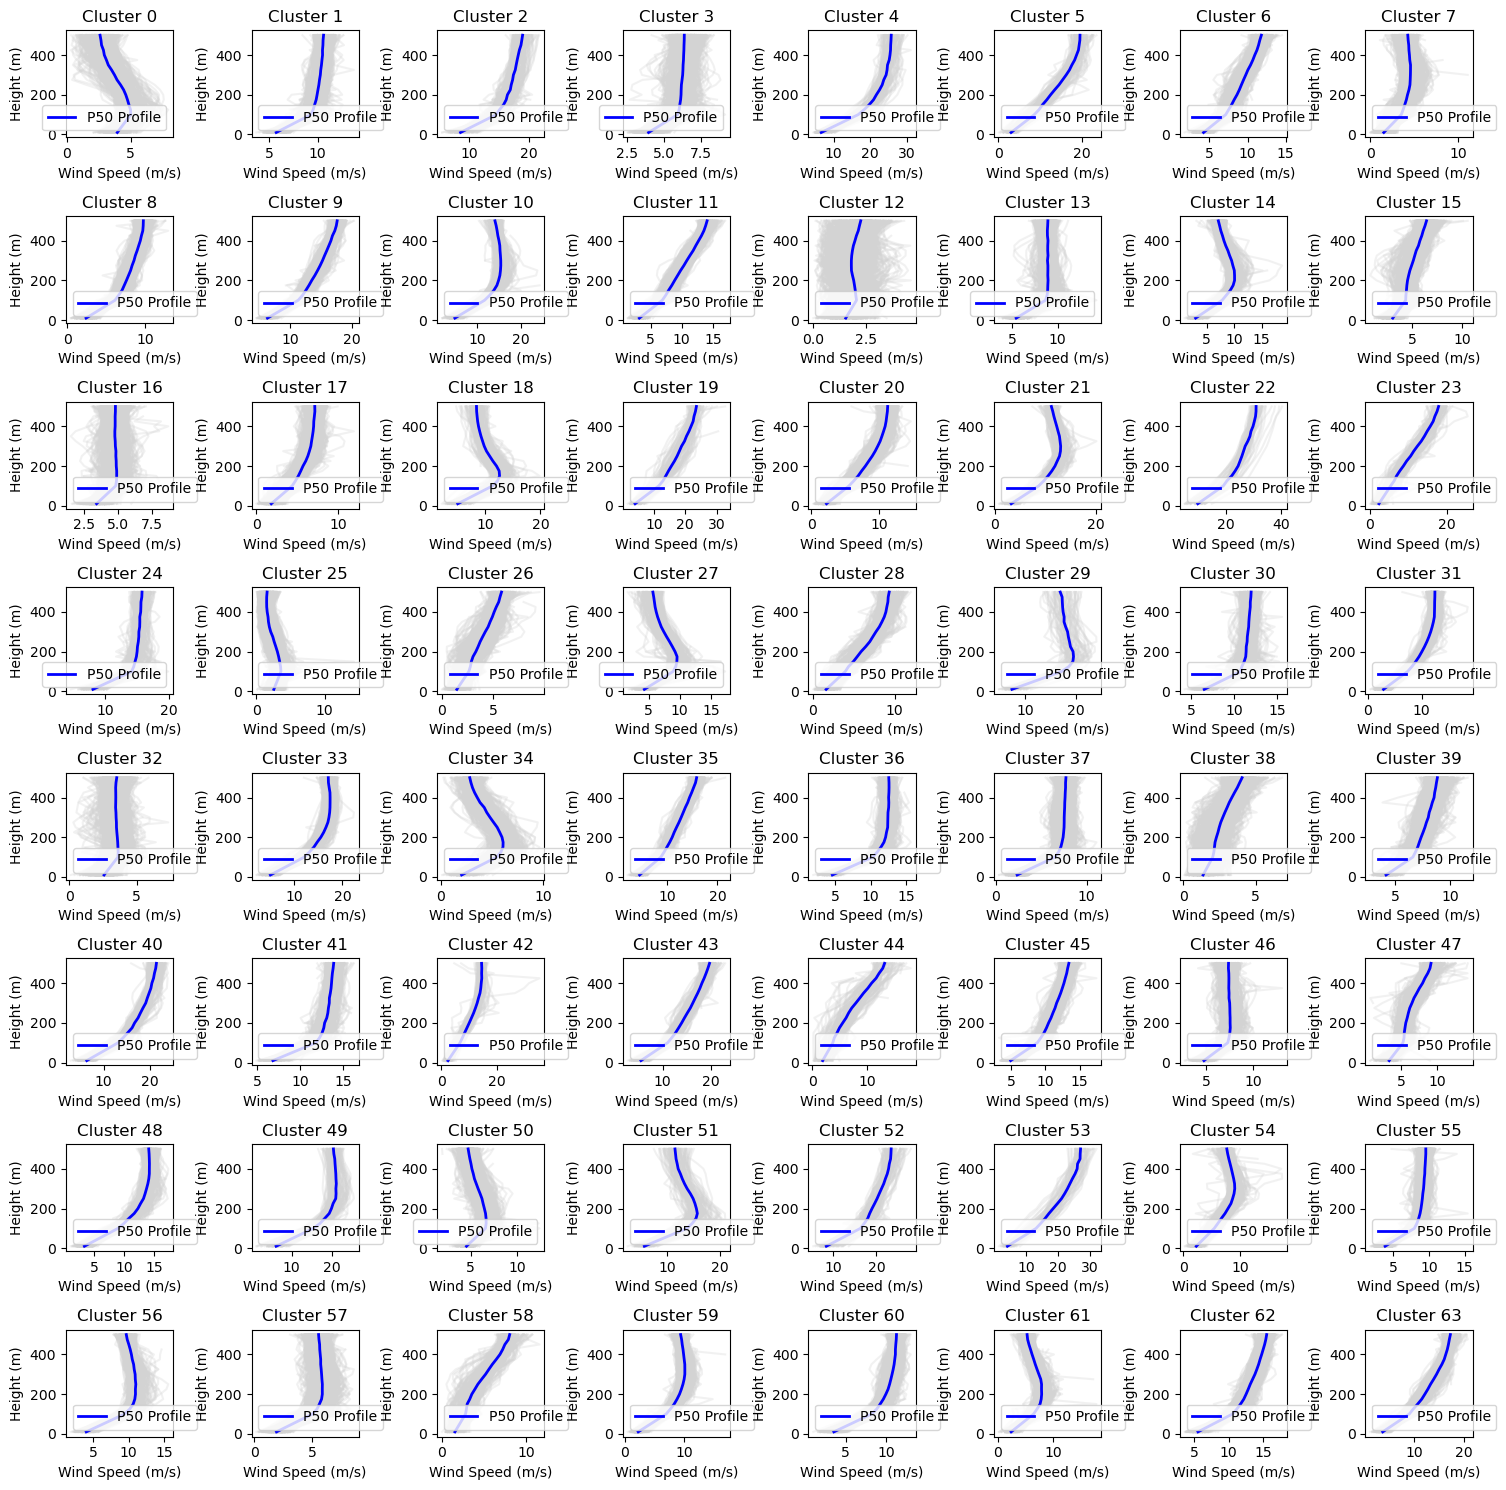

In [49]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(8,8, figsize=(15, 15))
Z = profilers_levels

count = 0
for i in range(n_clusters):
    profile = profiler_true_data.where(profiler_true_data.cluster == i, drop=True)
    count = count+profile.shape[0]
    print(f'Cluster {i}:', profile.shape)

    p50_profile = profile.median(dim='time')

    # Select the current subplot
    ax = axes[i // 8, i % 8]

    # Plot each wind profile in the ensemble in light color
    for prof in profile:
        ax.plot(prof, Z, color='lightgray', alpha=0.3)

    # Plot the P50 profile in a distinct color
    ax.plot(p50_profile, Z, color='blue', linewidth=2, label='P50 Profile')

    # Set labels and title for each subplot
    ax.set_xlabel('Wind Speed (m/s)')
    ax.set_ylabel('Height (m)')
    ax.set_title(f'Cluster {i}')
    ax.legend()

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [50]:
# Ensure reproducibility
np.random.seed(42)

# Parameters
Ens = 9
num_samples = 100
selected_clusters = [40, 10, 47, 8]
selected_clusters = [51]
wind_regimes = ['High shear','Well mixed','LLJ','Logarithmic']
wind_regimes = ['LLJ']
z_ml = np.arange(10, 500, 10)  # Height levels for ML profile

# Directory to save figures
save_dir = 'random_samples_plots'
os.makedirs(save_dir, exist_ok=True)

for j, wind_regime in enumerate(wind_regimes):
    # Loop through 50 samples
    fig, axes = plt.subplots(10, 10, figsize=(50, 50), sharey=True)
    axes = axes.flatten()
    for i in range(num_samples):
        cluster = selected_clusters[j]
        # Select random index within the chosen cluster
        random_index = np.random.randint(0, profiler_true_data.where(profiler_true_data.cluster == cluster, drop=True).sizes["time"])
        time_instance = profiler_true_data.where(profiler_true_data.cluster == cluster, drop=True).time[random_index].values

        # Profiler data
        M_profiler = profiler_true_data.sel(time=time_instance).values
        Coeff_profiler = profiler_data.sel(time=time_instance).values
        z_profiler = profilers_levels
        Mp_profiler = WindProfile(z_profiler, Coeff_profiler, poly_order=4, CPtype=1, ref_H=ref_H)
        axes[i].plot(M_profiler, z_profiler, 'or', markerfacecolor='r', label='True profile')
        axes[i].plot(Mp_profiler, z_profiler, '-k', linewidth=2, label='Chebyshev Profile')

        # NOW23 data
        M_NOW23 = NOW23_true_data.sel(time=time_instance).values
        Coeff_NOW23 = NOW23_data.sel(time=time_instance).values
        z_NOW23 = NOW23_levels
        Mp_NOW23 = WindProfile(z_NOW23, Coeff_NOW23, poly_order=4, CPtype=1, ref_H=ref_H)
        axes[i].plot(M_NOW23, z_NOW23, 'ob', markerfacecolor='b', label='NOW23 profile')
        axes[i].plot(Mp_NOW23, z_NOW23, '-g', linewidth=2, label='Chebyshev NOW23 profile')

        # ML prediction
        X = X_test.sel(time=time_instance).values.reshape(1, -1)
        model_output_dir = f'trained_models/{experiment}/9_stations/{hourly_data_method}/2021_to_2023/{segregated}/{transformed}/{loss_function}/Ens{Ens}'
        fSTR = f'{model_output_dir}/TabNet_HOLDOUT.pkl'
        with open(fSTR, "rb") as f:
            tabReg = pickle.load(f)
        
        Y_pred = tabReg.predict(X).reshape(-1, 1)

        if transformed == 'transformed':
            min_max_scaler = joblib.load(f'{model_output_dir}/min_max_scaler.joblib')
            Y_pred = min_max_scaler.inverse_transform(Y_pred)
        
        Mp_ml = WindProfile(z_ml, Y_pred, poly_order=4, CPtype=1, ref_H=ref_H)
        axes[i].plot(Mp_ml, z_ml, '-g', marker='o', markerfacecolor='g', label='ML profile')

        # Set titles, labels, and add legend
        axes[i].set_title(f'{time_instance}')
        axes[i].set_xlabel('Wind Speed (m/s)')
        if i == 0:
            axes[i].set_ylabel('Height (m)')
        axes[i].legend(loc='best')

    # Adjust layout and save plot
    plt.tight_layout()
    fig.savefig(f"{save_dir}/{station_id}_{wind_regime}.png")
    plt.close(fig)

print(f"All {num_samples} sample plots saved to '{save_dir}' directory.")

All 100 sample plots saved to 'random_samples_plots' directory.
